# 2 Bayesian Regression: Inference Algorithms

In [1]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints as C

import pyro
import pyro.distributions as D
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.2')

In [2]:
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [74]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", D.Normal(0., 10.))
    b_a = pyro.sample("bA", D.Normal(0., 1.))
    b_r = pyro.sample("bR", D.Normal(0., 1.))
    b_ar = pyro.sample("bAR", D.Normal(0., 1.))
    sigma = pyro.sample("sigma", D.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", D.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=C.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=C.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=C.positive)
    a = pyro.sample("a", D.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", D.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", D.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", D.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", D.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [75]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


In [76]:
from pyro.infer import SVI, Trace_ELBO
from tqdm import trange


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

pyro.clear_param_store()
num_iters = 5000 
for i in trange(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)

100%|██████████| 5000/5000 [00:24<00:00, 206.37it/s]


In [77]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [78]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%      75%      95%
0  9.163877  0.071347  9.047698  9.114647  9.162666  9.20934  9.28795 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.919531  0.156021 -2.172514 -2.023609 -1.920119 -1.819148 -1.656242 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.166681  0.044324 -0.238333 -0.196961 -0.165234 -0.136053 -0.094522 

Site: bAR
       mean       std        5%       25%    50%       75%       95%
0  0.301855  0.072188  0.186899  0.253054  0.301  0.350749  0.420441 

Site: sigma
       mean       std        5%       25%       50%       75%      95%
0  0.933527  0.049224  0.852629  0.899059  0.933498  0.966834  1.01224 



## HMC: Hamiltonian Monte Carlo

In [79]:
from pyro.infer import NUTS, MCMC 

In [80]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|██████████| 1200/1200 [00:28, 42.69it/s, step size=3.54e-01, acc. prob=0.886]


In [81]:
hmc_samples = {k: v.detach().numpy() for k, v in mcmc.get_samples().items()}

In [82]:
for site, values in summary(hmc_samples).items():
    print(f'Site: {site}')
    print(values, '\n')

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.173337  0.140345  8.940737  9.077632  9.175197  9.262259  9.409303 

Site: bA
       mean      std        5%       25%       50%       75%       95%
0 -1.837165  0.23211 -2.208884 -1.994768 -1.845803 -1.690607 -1.450819 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.346655  0.131784  0.126545  0.259539  0.347684  0.437466  0.559119 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.179504  0.077693 -0.313002 -0.230385 -0.180158 -0.129992 -0.053762 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.951654  0.052107  0.872059  0.917653  0.947485  0.983918  1.042775 



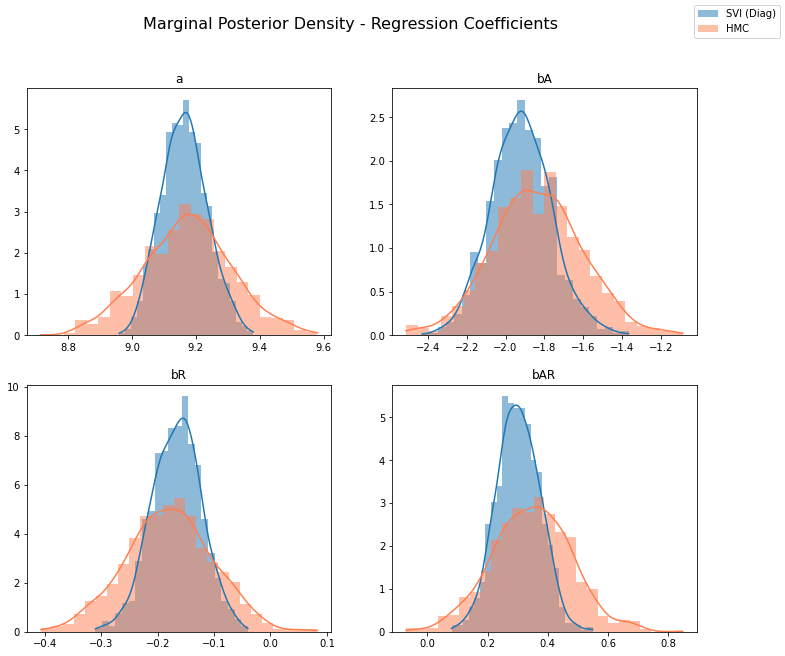

In [83]:
sites = ['a', 'bA', 'bR', 'bAR', 'sigma']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle('Marginal Posterior Density - Regression Coefficients', fontsize=16)

for i, ax in enumerate(axes.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, kde=True, linewidth=0, label='SVI (Diag)', stat='density')
    sns.histplot(hmc_samples[site], ax=ax, kde=True, linewidth=0, label='HMC', color='coral', stat='density')
    ax.set(title=site, ylabel='')

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels)
plt.show()
plt.close()

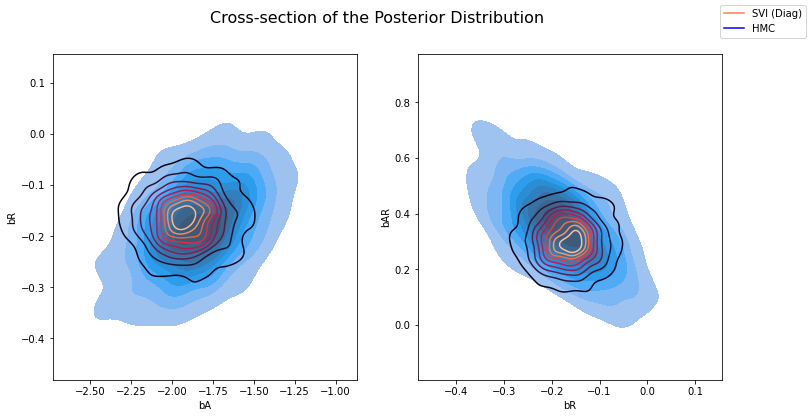

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Cross-section of the Posterior Distribution', fontsize=16)

ax = axes[0]
sns.kdeplot(x=hmc_samples['bA'], y=hmc_samples['bR'], ax=ax, shade=True, label='HMC')
sns.kdeplot(x=svi_samples['bA'], y=svi_samples['bR'], ax=ax, label='SVI', color='coral', cmap='rocket')
ax.set(xlabel='bA', ylabel='bR')

ax = axes[1]
sns.kdeplot(x=hmc_samples['bR'], y=hmc_samples['bAR'], ax=ax, shade=True)
sns.kdeplot(x=svi_samples['bR'], y=svi_samples['bAR'], ax=ax, cmap='rocket')
ax.set(xlabel='bR', ylabel='bAR')

ax.plot(0, 0, color='coral', label='SVI (Diag)')
ax.plot(0, 0, color='blue', label='HMC')
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels)

plt.show()
plt.close()

## Multivariate Normal Guide

In [85]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean 

In [86]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi = SVI(model, 
          guide,
          optim.Adam({'lr': .01}),
          loss=Trace_ELBO())

africa, rugged, gdp = train[:, 0], train[:, 1], train[:, 2]

pyro.clear_param_store()
for step in trange(num_iters):
    elbo = svi.step(africa, rugged, gdp)

100%|██████████| 5000/5000 [00:29<00:00, 169.17it/s]


In [87]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

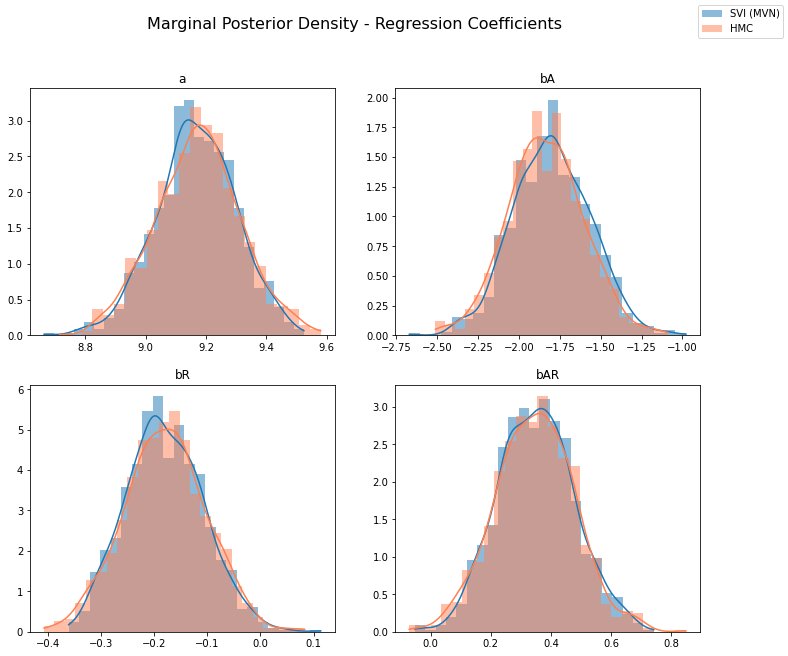

In [88]:
sites = ['a', 'bA', 'bR', 'bAR', 'sigma']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle('Marginal Posterior Density - Regression Coefficients', fontsize=16)

for i, ax in enumerate(axes.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_mvn_samples[site], ax=ax, kde=True, linewidth=0, label='SVI (MVN)', stat='density')
    sns.histplot(hmc_samples[site], ax=ax, kde=True, linewidth=0, label='HMC', color='coral', stat='density')
    ax.set(title=site, ylabel='')

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels)
plt.show()
plt.close()

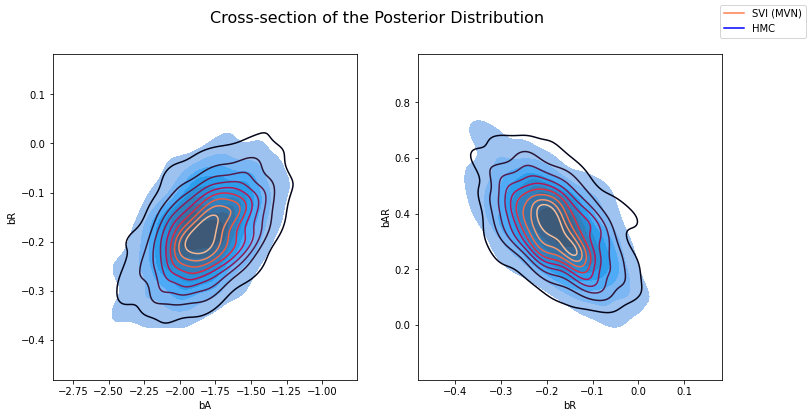

In [93]:
from cProfile import label


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Cross-section of the Posterior Distribution', fontsize=16)

ax = axes[0]
sns.kdeplot(x=hmc_samples['bA'], y=hmc_samples['bR'], ax=ax, shade=True, label='HMC')
sns.kdeplot(x=svi_mvn_samples['bA'], y=svi_mvn_samples['bR'], ax=ax, label='SVI', color='coral', cmap='rocket')
ax.set(xlabel='bA', ylabel='bR')

ax = axes[1]
sns.kdeplot(x=hmc_samples['bR'], y=hmc_samples['bAR'], ax=ax, shade=True)
sns.kdeplot(x=svi_mvn_samples['bR'], y=svi_mvn_samples['bAR'], ax=ax, cmap='rocket')
ax.set(xlabel='bR', ylabel='bAR')

ax.plot(0, 0, color='coral', label='SVI (MVN)')
ax.plot(0, 0, color='blue', label='HMC')
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels)

plt.show()
plt.close()

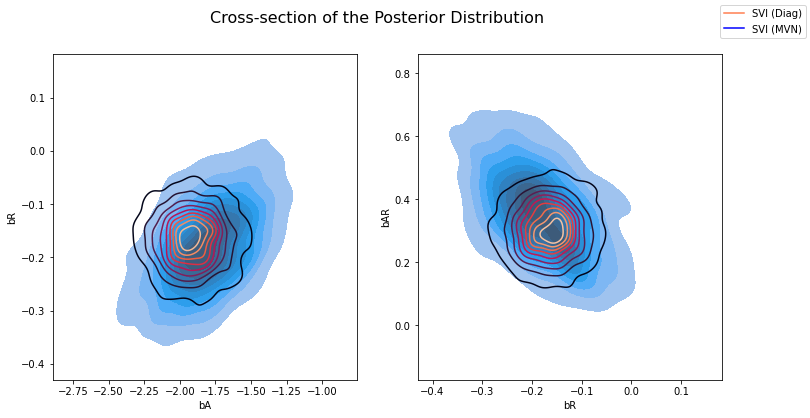

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Cross-section of the Posterior Distribution', fontsize=16)

ax = axes[0]
sns.kdeplot(x=svi_mvn_samples['bA'], y=svi_mvn_samples['bR'], ax=ax, shade=True, label='HMC')
sns.kdeplot(x=svi_samples['bA'], y=svi_samples['bR'], ax=ax, label='SVI', color='coral', cmap='rocket')
ax.set(xlabel='bA', ylabel='bR')

ax = axes[1]
sns.kdeplot(x=svi_mvn_samples['bR'], y=svi_mvn_samples['bAR'], ax=ax, shade=True)
sns.kdeplot(x=svi_samples['bR'], y=svi_samples['bAR'], ax=ax, cmap='rocket')
ax.set(xlabel='bR', ylabel='bAR')

ax.plot(0, 0, color='coral', label='SVI (Diag)')
ax.plot(0, 0, color='blue', label='SVI (MVN)')
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels)

plt.show()
plt.close()